## Comparing feature output for librosa and essentia

#### In order to extend the dcase baseline framework we need to know the differences between essentia and librosa. As the system is using librosa knowing the output form of the library will allow us to effectively connect on the framework all of the essentia descriptors. 

#### First example: one dimensional descriptor in librosa, in descriptors that don't depend of stft default window is square.

Shape of the output array: (1, 15786)
Shape of the output array: (1, 15786)


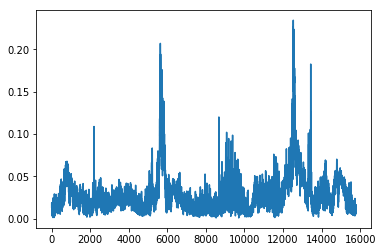

In [1]:

from essentia import *
from essentia.standard import *
import librosa 
import matplotlib.pyplot as plt
import numpy as np

#load an audio 

audio = MonoLoader(filename='a001.wav')()
zcr_librosa = librosa.feature.zero_crossing_rate(audio, frame_length=2048, hop_length=512, center=True)
print "Shape of the output array: " + str(zcr_librosa.shape)



plt.plot(zcr_librosa.T)
plt.show()




#### One dimensional descriptor in essentia

Shape of the output array: (15787,)


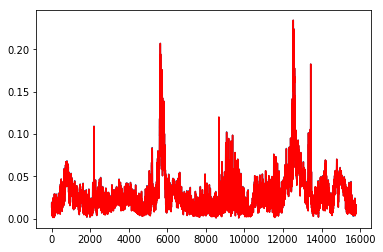

In [2]:

w = Windowing(type = 'square')
zcr = ZeroCrossingRate()
pool = essentia.Pool()


for frame in FrameGenerator(audio, frameSize=2048, hopSize=512, startFromZero=False):
    win = w(frame)
    zcr_frame = zcr(win)
    pool.add("lowlevel.zcr", zcr_frame)


print "Shape of the output array: " + str(pool["lowlevel.zcr"].shape)
plt.plot(pool["lowlevel.zcr"])
plt.plot(zcr_librosa.T, color = "red")
plt.show()

### Multidimensional descriptor in librosa

#### Librosa uses a default hanning window to compute the stft


Shape of the output array: (13, 15786)


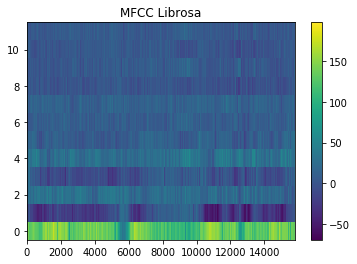

In [3]:
mfcc_librosa = librosa.feature.mfcc(y=audio, sr=44100, S=None, n_mfcc=13, fmax=11000)

print "Shape of the output array: " + str(mfcc_librosa.shape)

plt.imshow(mfcc_librosa[1:,:], aspect ="auto", origin='lower')
plt.title("MFCC Librosa")
plt.colorbar()
plt.show()

### Multidimensional descriptor in essentia

Shape of the output array: (15787, 13)


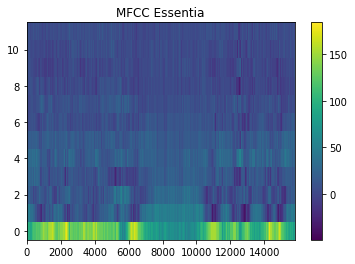

In [4]:


mfcc = MFCC()
spectrum = Spectrum()


for frame in FrameGenerator(audio, frameSize = 2048, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
    pool.add('lowlevel.mfcc', mfcc_coeffs)

print "Shape of the output array: " + str(pool["lowlevel.mfcc"].shape)
plt.imshow(pool['lowlevel.mfcc'].T[1:,:], aspect = 'auto',origin='lower')
plt.title("MFCC Essentia")
plt.colorbar()
plt.show()

### base implementation of a one dimensional descriptor


In [ ]:
def zero_crossing_rate(data):
        """Zero crossing rate

        Parameters
        ----------
        data : numpy.ndarray
            Audio data
        params : dict
            Parameters

        Returns
        -------

        """

        import librosa

        feature_matrix = []
        for channel in range(0, data.shape[0]):
            zero_crossing_rate = librosa.feature.zero_crossing_rate(y=data[channel, :],
                                                                    frame_length=2048,
                                                                    hop_length=512,
                                                                    center=True
                                                                    )

            zero_crossing_rate = zero_crossing_rate.reshape((-1, 1))
            feature_matrix.append(zero_crossing_rate)

        return feature_matrix

### Descriptor class extension with essentia

In [ ]:
from dcase_framework.features import FeatureExtractor

class CustomFeatureExtractor(FeatureExtractor):
    def __init__(self, *args, **kwargs):
        kwargs['valid_extractors'] = [
            'zero_crossing_rate',
        ]
        kwargs['default_parameters'] = {
            'zero_crossing_rate': {
                'mono': True,
                'center': True,
            },
        }



    def _zero_crossing_rate(self, data, params):
            """Zero crossing rate

            Parameters
            ----------
            data : numpy.ndarray
                Audio data
            params : dict
                Parameters

            Returns
            -------

            """

            from essentia.standard import *

            feature_matrix = []
            w = Windowing(type = 'hann')
            zcr = ZeroCrossingRate()
            pool = essentia.Pool()
            for channel in range(0, data.shape[0]):



                for frame in FrameGenerator(data[channel, :], frameSize=params.get('win_length_samples'), hopSize=params.get('hop_length_samples'), startFromZero=False):
                    win = w(frame)
                    zcr_frame = zcr(win)
                    pool.add("lowlevel.zcr", zcr_frame)


                zero_crossing_rate = pool["lowlevel.zcr"]
                feature_matrix.append(zero_crossing_rate)

            return feature_matrix